# Model Training
This is the stage in which we cook the ML solution. But just like cooking, we're gonna need some good ingredients first. Let's get our hands on what we have prepared so far.

In [1]:
# required library imports & initial settings

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error


# set seed value for reproducibility
RANDOM_SEED = 42


## Data Preprocessing

### Reading Cleaned Data

In [2]:
# define relative data path (according the current path of this notebook)
DATA_PATH = './script/data/'

df_train_full = pd.read_csv(DATA_PATH+'train_cleaned.csv.gz')
df_test_full  = pd.read_csv(DATA_PATH+'test_cleaned.csv.gz')

df_train_full.head()

,id,cat1,cat2,cat4,cat5,cat6,cat8,cat9,cat10,cat11,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont13,cont14,loss
0,1,A,B,B,A,A,A,B,A,B,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,B,B,A,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.611431,0.304496,1283.60
2,5,A,B,A,B,A,A,B,B,B,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.195709,0.774425,3005.09
3,10,B,B,B,A,A,A,B,A,A,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.605077,0.602642,939.85
4,11,A,B,B,A,A,A,B,B,A,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.246011,0.432606,2763.85


In [3]:
# specify feature groups
features_numerical   = [column for column in df_train_full if column.startswith('cont')]
features_categorical = [column for column in df_train_full if column.startswith('cat')]

### Transforming Target Column
We noticed in EDA stage that our target column in data could benefit from a log-transform. We'll apply that transform right here in the beginning before any splits, since we will be using stratified method and it is important for us to consider equal distribution of samples in all data chops, according to the target distribution.

<AxesSubplot:xlabel='loss', ylabel='Count'>

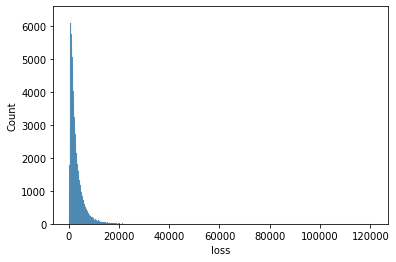

In [4]:
# check-out the target column value distribution before log-transform

name_of_target_column = 'loss'
sns.histplot(df_train_full[name_of_target_column])


In [5]:
name_of_target_column_transformed = name_of_target_column+'_transformed'

# logarithmic transform function
def log_transform(value):
    return np.log1p(value)

# create a new logarithmically transformed target column
df_train_full[name_of_target_column_transformed] = df_train_full.apply(
    lambda row: log_transform(row[name_of_target_column]), axis=1)

<AxesSubplot:xlabel='loss_transformed', ylabel='Count'>

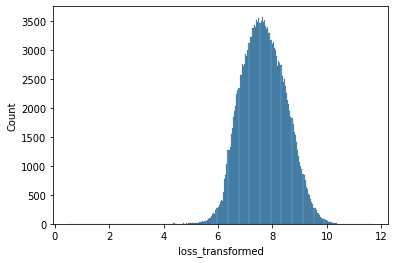

In [6]:
# check value distribution of transformed target column

sns.histplot(df_train_full[name_of_target_column_transformed])


### Data Splitting
We have a pretty sizable dataset with 180k+ rows. Needless to say, creating multiple test models and tuning them will take a long time. What should we do then?<br>
One simple trick I use in similar cases is to create a subsample dataset with smaller number of samples and apply and adjust training and tuning on this one. Later I can use the full train data and utilize the parameters I discovered.

In [7]:
# let's shuffle the whole dataframe before subsampling
df_train_full = df_train_full.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# second shuffle with an exponential random seed :D
df_train_full = df_train_full.sample(frac=1, random_state=(RANDOM_SEED**2)).reset_index(drop=True)


To make sure that the subsampled data is similar to our original full dataset, it is advised widely to use __stratified__ method in all sampling scenarios.

But we know that stratified sampling works only on classification problems, which have a target column with classes. Our problem here is of regression type and the target column contains continuous numerical values.

__So, what should we do to randomly subsample a fraction of data with samples that their target column values conform to distribution pattern in our original dataset?__<br>
Pandas _qcut()_ function to the rescue! We create discrete bins (groups) for our target column with (nearly) equal value counts in each bin, and do the subsampling using those bins.

In [8]:
name_of_target_column_binned = name_of_target_column+'_bin'

# 10 bin groups for target values should work fine
bin_counts = 10

# create bin column in our dataframe
df_train_full[name_of_target_column_binned] = pd.qcut(
    df_train_full[name_of_target_column_transformed],
    q=bin_counts,
    labels=list(range(bin_counts)))


I think a number around 25k samples is a decent chunk for a (train + validation) subsample:

In [9]:
desired_subsample_size = 25000
subsample_fold_split = int(len(df_train_full)/desired_subsample_size)

# create desired kfold splitter
skf_subsample_full = StratifiedKFold(
    n_splits=subsample_fold_split, shuffle=True, random_state=RANDOM_SEED)

# make sure target distribution remains the same by utilizing StratifiedKFold data split
train_indices_remaining, train_indices_subsample = next(
    skf_subsample_full.split(X=df_train_full, y=df_train_full[name_of_target_column_binned]), 0)

df_train_full_subsample = df_train_full.iloc[train_indices_subsample, :].reset_index(drop=True)


We should now separate the full subsample dataset into "subsample train" and "subsample validation" in similar manner:

In [10]:
skf_subsample_trainvalid = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=RANDOM_SEED)

train_indices_subsample, valid_indices_subsample = next(
    skf_subsample_trainvalid.split(X=df_train_full_subsample, y=df_train_full_subsample[name_of_target_column_binned]), 0)

df_train_subsample = df_train_full.iloc[train_indices_subsample, :].reset_index(drop=True)
df_valid_subsample = df_train_full.iloc[valid_indices_subsample, :].reset_index(drop=True)


Now let's check to see how closely the subsample (and it's train/valid splits) represents our full dataset:

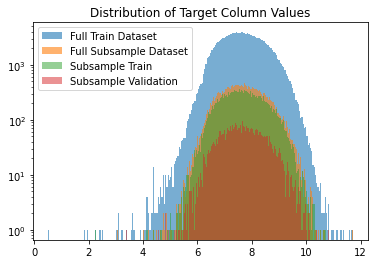

In [11]:
from matplotlib import pyplot as plt

plot_bins = 250

plt.hist(
    x=df_train_full[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.6,
    label='Full Train Dataset')
plt.hist(
    x=df_train_full_subsample[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.6,
    label='Full Subsample Dataset')
plt.hist(
    x=df_train_subsample[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.5,
    label='Subsample Train')
plt.hist(
    x=df_valid_subsample[name_of_target_column_transformed],
    bins=plot_bins,
    alpha=0.5,
    label='Subsample Validation')

plt.yscale('log')
plt.legend(loc='upper left')
plt.title('Distribution of Target Column Values')
plt.rcParams['figure.figsize'] = (1, 1)
plt.show()


Distributions look pretty similar. That's great news!<br>
__Note:__ The _'Y'_ values (indicating sample counts) in above plot are logarithmically scaled for easier comparison.

Now that we're done with splits, it's time to build out the dataframes containing only feature columns, and of course the target column series.

In [12]:
features_all = features_numerical + features_categorical

X_train_subsample = df_train_subsample[features_all].copy()
X_valid_subsample = df_valid_subsample[features_all].copy()

y_train_subsample = df_train_subsample[name_of_target_column_transformed].to_numpy()
y_valid_subsample = df_valid_subsample[name_of_target_column_transformed].to_numpy()


### Transforming Numerical Features
During EDA we noticed the following characteristics for numerical features:<br>
- Gaussian-like: _['cont1', 'cont2', 'cont3', 'cont6', 'cont7', 'cont9', 'cont11', 'cont12']_<br>
- Non-Gaussian-like: _['cont4', 'cont5', 'cont8', 'cont10', 'cont13', 'cont14']_

As a rule of thumb, we'll use min-max scaler for non-gaussian features, and standard scaler for gaussian-like features.

You should remember that we dropped some columns in data cleaning step. We should adjust column names in above groups, having that in mind.

In [13]:
gaussian_like = ['cont1', 'cont2', 'cont3', 'cont6', 'cont7', 'cont9', 'cont11', 'cont12']
non_gaussian_like = ['cont4', 'cont5', 'cont8', 'cont10', 'cont13', 'cont14']

features_numerical_to_normalize = [column for column in gaussian_like if column in df_train_subsample.columns.to_list()]
features_numerical_to_standardize = [column for column in non_gaussian_like if column in df_train_subsample.columns.to_list()]

### Handling Categorical Features
We talked about the curse of dimensionality in EDA stage. For categorical columns, if the cardinality of a column is below 10, we'll nominate it for one-hot encoding; otherwise it goes to ordinal encoding list.

In [14]:
features_categorical_to_ordinal = list()
features_categorical_to_onehot  = list()

for column, variety in X_train_subsample[features_categorical].nunique().iteritems():
    if variety < 10: features_categorical_to_onehot.append(column)
    else: features_categorical_to_ordinal.append(column)


Let's utilize __sk-learn's pipeline__ feature to do the transformations in an efficient way:

In [15]:
# create transform pipeline for numerical features
transformer_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('normalizer', MinMaxScaler()),
    ('standardizer', StandardScaler()),
])

# create transform pipelines for categorical features
transformer_categorical_1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('normal',  MinMaxScaler()),
])
transformer_categorical_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num',  transformer_numerical, features_numerical),
        ('cat1', transformer_categorical_1, features_categorical_to_ordinal),
        ('cat2', transformer_categorical_transformer2, features_categorical_to_onehot),
    ])


## Models Training & Tuning Hyperparameters
We'll cover three models for this study, starting from the simplest & fastest one, __"Linear Regression"__. Later we explore more sophisticated models, tree-based to be clear, __"Random Forest"__ & __"XGBoost"__.

Hyperparameter tuning can be handled either automatically or manually. Actually there are many fantastic tools for automatic solutions if you google it. For the sake of simplicity we'll stick to manual approach and tune a couple of important parameters step by step, and one by one, __moving from the most significant to the least__.

### Linear Regression Model

### Random Forest


#### Random Forest Initial Training

In [59]:
model_rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)

# bundle preprocessing and modeling in a final pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# preprocess train data & fit model
pipeline_rf.fit(X_train_subsample, y_train_subsample)

print()

In [60]:
y_pred_subsample = pipeline_rf.predict(X_valid_subsample)

# preprocess validation data and get predictions to evaluate the model
# don't forget to transfer back target values after inference prediction with np.expm1() ;)
score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
print('MAE Score:', score_mae_rf)


MAE Score: 1251.7648342556438


#### Random Forest Hyperparameter Tuning

In [45]:
tune_subject = 'Max Depth'
tune_values  = [3, 5, 10, 15, 20, 25, 30]

scores = list()
print(f'<<MAE Scores for Random Forest Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_rf = RandomForestRegressor(max_depth=value, random_state=RANDOM_SEED, n_jobs=-1)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    pipeline_rf.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_rf.predict(X_valid_subsample)
    score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_rf))
    print(f'{value} \t {round(score_mae_rf, 4)}')

<<MAE Scores for Random Forest Model :: Study Parameter: Max Depth>>
Val.	Score
3 	 1430.521
5 	 1348.5531
10 	 1269.5775
15 	 1254.3561
20 	 1250.9533
25 	 1252.6426
30 	 1251.1197


There it is the best one. We move on with max_depth=20 from here.

In [52]:
tune_subject = 'Number of Estimators'
tune_values = list(range(50, 300, 50))

scores = list()
print(f'<<MAE Scores for Random Forest Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_rf = RandomForestRegressor(max_depth=20, n_estimators=value, random_state=RANDOM_SEED, n_jobs=-1)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    pipeline_rf.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_rf.predict(X_valid_subsample)
    score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_rf))
    print(f'{value} \t {round(score_mae_rf, 4)}')


<<MAE Scores for Random Forest Model :: Study Parameter: Number of Estimators>>
Val.	Score
50 	 1258.1482
100 	 1250.9533
150 	 1249.169
200 	 1248.4397
250 	 1248.6593


We'll continue with n_estimators=200.

In [53]:
tune_subject = 'Max Number of Features for Splitting'
tune_values = [8, 16, 32, 40, 48, 56, 64, 72, 80]

scores = list()
print(f'<<MAE Scores for Random Forest Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    model_rf = RandomForestRegressor(max_depth=20, n_estimators=200,
        max_features=value, random_state=RANDOM_SEED, n_jobs=-1)
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_rf)
    ])
    pipeline_rf.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_rf.predict(X_valid_subsample)
    score_mae_rf = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_rf))
    print(f'{value} \t {round(score_mae_rf, 4)}')


<<MAE Scores for Random Forest Model :: Study Parameter: Max Number of Features for Splitting>>
Val.	Score
8 	 1276.9501
16 	 1250.7871
32 	 1242.985
40 	 1241.9461
48 	 1240.6981
56 	 1239.9349
64 	 1242.188
72 	 1238.2277
80 	 1240.6245


This brings our RF tuning to an end. The best hyperparameters are:
```
max_depth=20
n_estimators=200
max_features=56
```

### XGBoost


#### XGBoost Initial Training

In [71]:
model_xgb = xgb.XGBRegressor()
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_xgb)
])
pipeline_xgb.fit(X_train_subsample, y_train_subsample)

y_pred_subsample = pipeline_xgb.predict(X_valid_subsample)
score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
print('MAE Score:', score_mae_xgb)


MAE Score: 1223.4211677762921


#### XGBoost Hyperparameter Tuning

We can use __gpu__ for faster hyperparameter search. If you have a compatible gpu, enable this option by setting it enabled in following line:

In [75]:
gpu_enabled = True

tree_method_applied = 'gpu_hist' if gpu_enabled else 'auto'


In [78]:
tune_subject = 'Number of Estimators'
tune_values = list(range(20, 100, 5))

scores = list()
print(f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'n_estimators': value,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')


<<MAE Scores for XGBoost Model :: Study Parameter: Number of Estimators>>
Val.	Score
20 	 1220.7585
25 	 1212.3367
30 	 1205.01
35 	 1205.8681
40 	 1206.8926
45 	 1206.2272
50 	 1205.4982
55 	 1209.66
60 	 1208.4578
65 	 1208.4743
70 	 1209.7424
75 	 1210.0238
80 	 1210.8627
85 	 1212.1921
90 	 1215.8706
95 	 1218.2615


There we go. Our preferred n_estimators equals 30.

In [83]:
tune_subject = 'Max Depth'
tune_values = list(range(2, 11, 1))

scores = list()
print(
    f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'max_depth': value,
        'n_estimators': 30,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(
        np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')


<<MAE Scores for XGBoost Model :: Study Parameter: Max Depth>>
Val.	Score
2 	 1260.5824
3 	 1222.3614
4 	 1210.7759
5 	 1205.4412
6 	 1205.01
7 	 1207.8981
8 	 1227.9128
9 	 1250.1969
10 	 1247.2156


The depth with value 6 is our choice.

In [94]:
tune_subject = 'Learning Rate'
tune_values = [round(item, 2) for item in np.arange(0.1, 0.3, 0.01)]

scores = list()
print(f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'eta': value,
        'max_depth': 6,
        'n_estimators': 30,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')


<<MAE Scores for XGBoost Model :: Study Parameter: Learning Rate>>
Val.	Score
0.1 	 1464.9177
0.11 	 1370.7784
0.12 	 1314.1458
0.13 	 1275.7434
0.14 	 1251.7331
0.15 	 1236.7471
0.16 	 1219.0251
0.17 	 1213.4802
0.18 	 1211.7185
0.19 	 1212.8984
0.2 	 1201.7133
0.21 	 1210.9485
0.22 	 1207.23
0.23 	 1199.7316
0.24 	 1203.3186
0.25 	 1202.6958
0.26 	 1205.0798
0.27 	 1210.61
0.28 	 1218.2772
0.29 	 1211.2089


The ideal learning rate would be 0.23.

In [100]:
tune_subject = 'Subsample Ratio'
tune_values = [round(item, 2) for item in np.arange(0.8, 1.01, 0.01)]

scores = list()
print(f'<<MAE Scores for XGBoost Model :: Study Parameter: {tune_subject}>>\nVal.\tScore')
for value in tune_values:
    xgb_params = {
        'eta': 0.23,
        'max_depth': 6,
        'n_estimators': 30,
        'subsample': value,

        'objective': 'reg:squarederror',
        'nthread': -1,
        'tree_method': tree_method_applied,

        'seed': RANDOM_SEED,
        'verbosity': 1,
    }

    model_xgb = xgb.XGBRegressor(**xgb_params)
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_xgb)
    ])
    pipeline_xgb.fit(X_train_subsample, y_train_subsample)

    y_pred_subsample = pipeline_xgb.predict(X_valid_subsample)
    score_mae_xgb = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
    scores.append((value, score_mae_xgb))
    print(f'{value} \t {round(score_mae_xgb, 4)}')


<<MAE Scores for XGBoost Model :: Study Parameter: Subsample Ratio>>
Val.	Score
0.8 	 1198.0412
0.81 	 1209.7342
0.82 	 1210.6296
0.83 	 1203.6598
0.84 	 1212.6996
0.85 	 1205.8743
0.86 	 1212.0091
0.87 	 1210.9594
0.88 	 1206.6629
0.89 	 1206.6421
0.9 	 1191.9369
0.91 	 1206.6319
0.92 	 1203.9524
0.93 	 1201.693
0.94 	 1199.5656
0.95 	 1207.9843
0.96 	 1203.9203
0.97 	 1205.1545
0.98 	 1208.0474
0.99 	 1205.0366
1.0 	 1199.7316


Ok, 0.9 for subsample ratio works the best here! This wraps up our XGBoost tuning.

### Choosing The Best Model
XGBoost performed the best among tuned three models discussed here. That will be our go-to model for final train on data and our train script.

## Final Training on All Data

In [139]:
X_train = df_train_full[features_all].copy()
y_train = df_train_full[name_of_target_column_transformed].to_numpy()
X_test = df_test_full[features_all].copy()


gpu_enabled = True
tree_method_applied = 'gpu_hist' if gpu_enabled else 'auto'

# tuned hyperparameters
xgb_params_final = {
    'eta': 0.23,
    'max_depth': 6,
    'n_estimators': 30,
    'subsample': 0.9,

    'objective': 'reg:squarederror',
    'nthread': -1,
    'tree_method': tree_method_applied,

    'seed': RANDOM_SEED,
    'verbosity': 1,
}

model_final = xgb.XGBRegressor(**xgb_params_final)
pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_final)
])
pipeline_final.fit(X_train, y_train)

y_pred_test = np.expm1(pipeline_final.predict(X_test))

print('Training finished :)')


Training finished :)


In [140]:
# test the final model on the same subsample validation bunch
y_pred_subsample = pipeline_final.predict(X_valid_subsample)
score_mae_subsample_final = mean_absolute_error(np.expm1(y_valid_subsample), np.expm1(y_pred_subsample))
print('MAE Score:', score_mae_subsample_final)


MAE Score: 1156.6538551622903


As we expected, training on all data improved subsampled data score.